<a href="https://colab.research.google.com/github/aCStandke/GAN_Models/blob/main/NeuralTransferModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

This is an implementation of the Neural Style Transfer tutorial as detailed at [Neural style transfer](https://www.tensorflow.org/tutorials/generative/style_transfer)

> This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as neural style transfer and the technique is outlined in [A Neural Algorithm of Artistic Style (Gatys et al.)](https://arxiv.org/pdf/1508.06576.pdf).

> ⭐**Note:** This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to CycleGAN). This approach is much faster (up to 1000x).

> For a simple application of style transfer with a pretrained model from [TensorFlow Hub](https://tfhub.dev/), check out the [Fast style transfer for arbitrary styles tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) that uses an arbitrary image stylization model. For an example of style transfer with TensorFlow Lite, refer to [Artistic style transfer with TensorFlow Lite.](https://www.tensorflow.org/lite/examples/style_transfer/overview)

> Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

> This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.


In [1]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
# loading the images and styles
me_path = []
art_paths = []

for i in sorted(os.listdir("/content/drive/MyDrive/Datasets/NTM/")):
  me_path.append(os.path.join("/content/drive/MyDrive/Datasets/NTM/", i))
for i in sorted(os.listdir("/content/drive/MyDrive/Datasets/style/")):
  art_paths.append(os.path.join("/content/drive/MyDrive/Datasets/style/", i))

# Visualizing Inputs

In [4]:
# function to convert tensor to image
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
# function to load in images and clip to 512
def load_img(path_to_img):
  max_dim = 512
  # reading image
  img = tf.io.read_file(path_to_img)
  # decocing image
  img = tf.image.decode_image(img, channels=3)
  # converting image to float32
  img = tf.image.convert_image_dtype(img, tf.float32)
  # clipping the longest dim of image to 512
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# function to display images
def imshow(image, title=None):
  if len(image.shape)>3:
    image = tf.squeeze(image, axis=0)
  #plt.axis("off")
  if title:
    plt.title(title)
  plt.imshow(image)


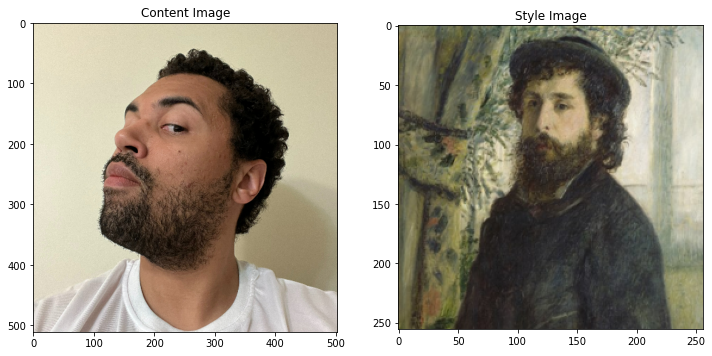

In [6]:
# Link Profile
content_image = load_img(me_path[1])
style_image = load_img(art_paths[1])
style_image = tf.image.resize(style_image, (256, 256))

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Fast Style Transfer using TF-Hub

Using TensorFlow's pre-trained model as can be found at [TensorFlow Hub Models](https://tfhub.dev/)


### Overview
As detailed by [tfhub](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) 
> The original work for artistic style transfer with neural networks proposed a slow optimization algorithm that works on any arbitrary painting. Subsequent work developed a method for fast artistic style transfer that may operate in real time, but was limited to one or a limited set of styles.
This module performs fast artistic style transfer that may work on arbitrary painting styles as described in [1].

### Example Use


```
# Load content and style images
content_image = plt.imread(content_image_path)
style_image = plt.imread(style_image_path)
# Convert to float32 numpy array, add batch dimension, and normalize to range [0, 1]. Example using numpy:
content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.
style_image = style_image.astype(np.float32)[np.newaxis, ...] / 255.
# Optionally resize the images. It is recommended that the style image is about
# 256 pixels (this size was used when training the style transfer network).
# The content image can be any size.
style_image = tf.image.resize(style_image, (256, 256))

# Load image stylization module.
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Stylize image.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

```

[1](https://arxiv.org/pdf/1705.06830.pdf)


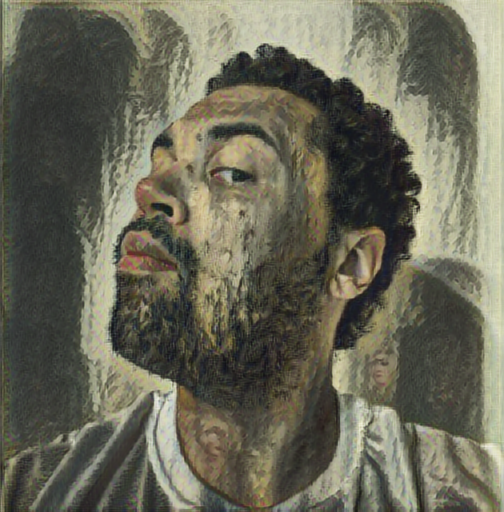

In [7]:
import tensorflow_hub as hub
hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# Loading VGG-19 Pre-trained Model

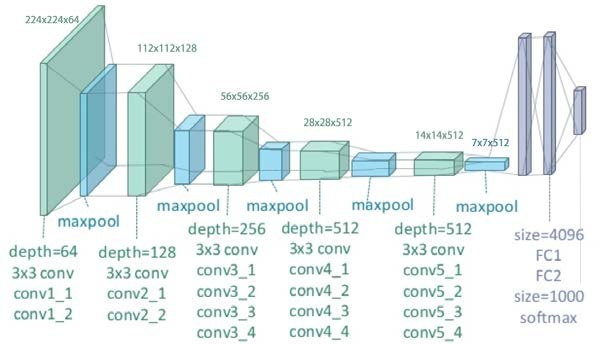



For style transfer the fully connected layers are not used; only the convolutional layers are used. This is the following architecture the paper uses:

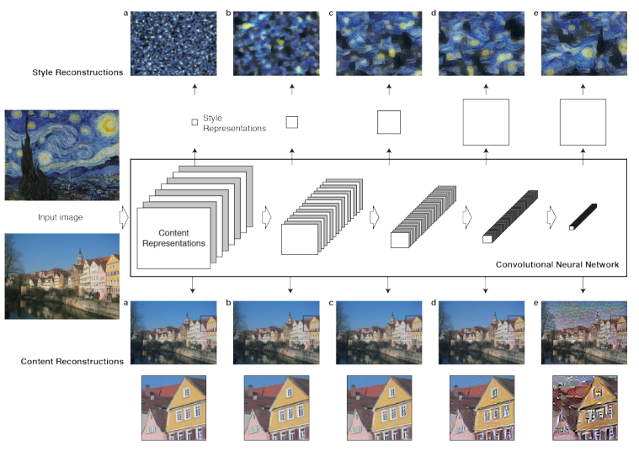

For this tutorial, the style feature maps were the following conolutional layers: conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 and the content feature map(s) were the following convolutional layers: conv5_2. 

In [8]:
# Loading the pretrained  VGG-19 model without the fully connected layers from Keras applications module 
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') 

In [9]:
# Listing the intermediate layer names of VGG-19 model
vgg.summary() 

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# Replacing MaxPooling2d Layers of Pre-trained VGG-19 Model with AveragePooling2d

As the paper states eventhough the VGG-19 CNN Network was used,the max pooling operations were replaced by average pooling operations, since the authors found that the gradient flow was improved leading to better results. Since this model has already been pretrained, I found this hack on stackoverflow on [how to build a new model based on a subset of layers from a pre-trained model](https://stackoverflow.com/questions/54508800/why-replacing-max-pool-by-average-pool-using-keras-apis-fails). As Daniel Möller details:
> The cause is that whenever you reuse a layer (you're reusing layers when creating the new branch with avg poolings), you create a new node in the graph.
**The original model still exists, and uses the nodes of index 0 for all layers, while your new model uses the nodes of index 1.**

**Hack suggestion** ⭐  
> Saving and loading models in Keras offers a system (initially meant for custom layers and custom functions) in which you define what keras should use for class names and function names it doesn't know. Loading a model is "creating a model again with saved parameters". So, if you use this system to "replace" an existing name, it should work replacing layers during the model reconstruction.

```
custom_objects = {'MaxPooling2D': AveragePooling2D} 
vgg.save_model(filename)
vgg_ag = keras.models.load_model(filename, custom_objects = custom_objects)
```
> If this doesn't work, you can make a custom function that returns an avg pooling using the given parameters like:

```
def createAvgFromMax(**params):

    #study the params, choose what to keep and discard
    return AveragePooling2D(....)

custom_objects = { 'MaxPooling2D': createAvgFromMax }  

```



In [10]:
custom_objects = {'MaxPooling2D': tf.keras.layers.AveragePooling2D} 
vgg.save('/content/drive/MyDrive/CustomVgg')
vgg_avg = tf.keras.models.load_model('/content/drive/MyDrive/CustomVgg', custom_objects=custom_objects)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CustomVgg/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CustomVgg/assets


In [11]:
vgg_avg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (AveragePooling  (None, None, None, 64)   0         
 2D)                                                             
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                             

# Building the Model

In [12]:
# Choosing which intermediate layers from the network to represent the style and content of the image
content_layers = ['block5_conv2']
style_layers =['block1_conv1',
               'block2_conv1', 
               'block3_conv1', 
               'block4_conv1',
               'block5_conv1']

In [13]:
# function that takes in the VGG model; returns a model with the style layers
def vgg_layers(layer_names, vgg):
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

style_feature_extractor = vgg_layers(style_layers, vgg_avg)
style_outputs = style_feature_extractor(style_image*255) # style_image = eagerTensor

#Look at the statistics of each layer's output when passing in the style_image
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()


block1_conv1
  shape:  (1, 256, 256, 64)
  min:  0.0
  max:  775.4111
  mean:  19.79657

block2_conv1
  shape:  (1, 128, 128, 128)
  min:  0.0
  max:  1912.1876
  mean:  96.27707

block3_conv1
  shape:  (1, 64, 64, 256)
  min:  0.0
  max:  2544.006
  mean:  65.76057

block4_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  3910.8865
  mean:  196.908

block5_conv1
  shape:  (1, 16, 16, 512)
  min:  0.0
  max:  410.63867
  mean:  9.464451



##### **Gram Matrix**

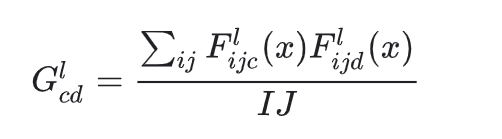

The content of an image is represented by the values of the intermediate feature maps.It turns out, the style of an image can be described by the means and correlations across the different feature maps. A Gram matrix that includes 
this information can be calculated by taking the outer product of the feature 
vector with itself at each location, and averaging that outer product over all 
locations. This is implemented using tensorflows linear algerbra module

In [14]:
# function that calculates the Gram matrix

def gram_matrix(input_tensor):
  # perorms batch matrix multiplication using Einstein notation (i.e. numerator portion of formula)
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  # calculating denominator portion of formula 
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


##### **Attaching Style (i.e. Gram Matrix) and Content to Intermediate Layers and Returning the Style and Content Tensors**

In [15]:
# sub-class that inherits from the tf.keras.models.Model super-class
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, vgg):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers+content_layers,vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # model expects float inputs in [0,255] range
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
    
    # does the styling portion with the Gram Matrix by taking as input the 
    # 4d style feature maps (i.e. (batch, w, h, depth))
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    # value contains the 4d content feature maps (i.e. (batch, w, h, depth))  
    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    
    # value contains the 3d style Gram Matrices (i.e. (batch, c, d))
    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

# Training

In [16]:
# setting the target values used for training
extractor = StyleContentModel(style_layers, content_layers, vgg_avg)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# helper function to keep the pixel values between 0 and 1
def clip(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [68]:
'''defining tf.Variable to contain the image to optimize. To make training
faster the content image is used rather than white noise used in the paper'''
image = tf.Variable(content_image)

'''paper used a ratio of alpha/beta equal to either 1e-3 or 1e-4'''
# content weight
alpha = 1
# style weight
beta = 1000
# num of style layers used for weighting
num_style_layers = 5
# num of content layers used for weighting
num_content_layers= 1
# TO DO
total_variation_weight= 30

img_height = 503
img_width  = 511

#
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [80]:
def losses(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  # calculating content loss
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
  content_loss *= alpha/num_content_layers
  # calcualting style loss
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
  style_loss *= beta/num_style_layers
  loss = content_loss+style_loss
  return loss  

In [83]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = losses(outputs)
    loss += total_variation_weight * tf.image.total_variation(image)
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip(image))

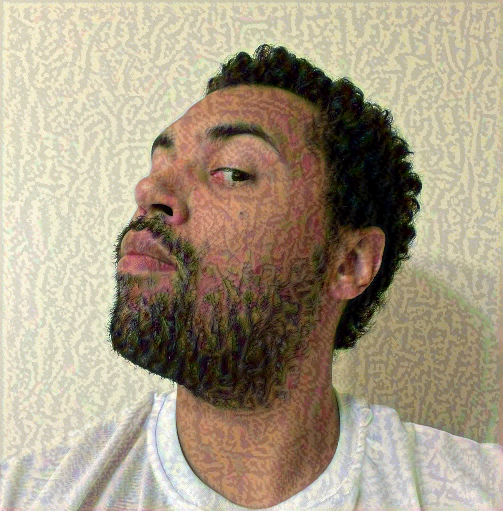

In [84]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)